In [27]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
with open('.rcparams.json', 'r') as fh:
    matplotlib.rcParams.update(json.load(fh))

In [69]:
cwd = os.getcwd()

data_dir = os.path.abspath('./data')
dataset_path = os.path.join(data_dir,'dataset.csv')

dataset = pd.read_csv(dataset_path, sep=',', index_col=0)
dataset.rep = dataset.rep.astype(int)
dG = dataset.groupby('name').agg({'dG': 'first'})

In [70]:
rmsd = {}
for name in np.unique(dataset.name):
    rmsd[name] = []
    rms_path = dataset[dataset.name==name]
    for fpath in rms_path.trj_rms:
        with open(fpath, 'r') as fh:
            data = json.load(fh)
        for entry in data:
            if entry['type'] == 'rmsd':
                rmsd[name].append(entry['results'])
        

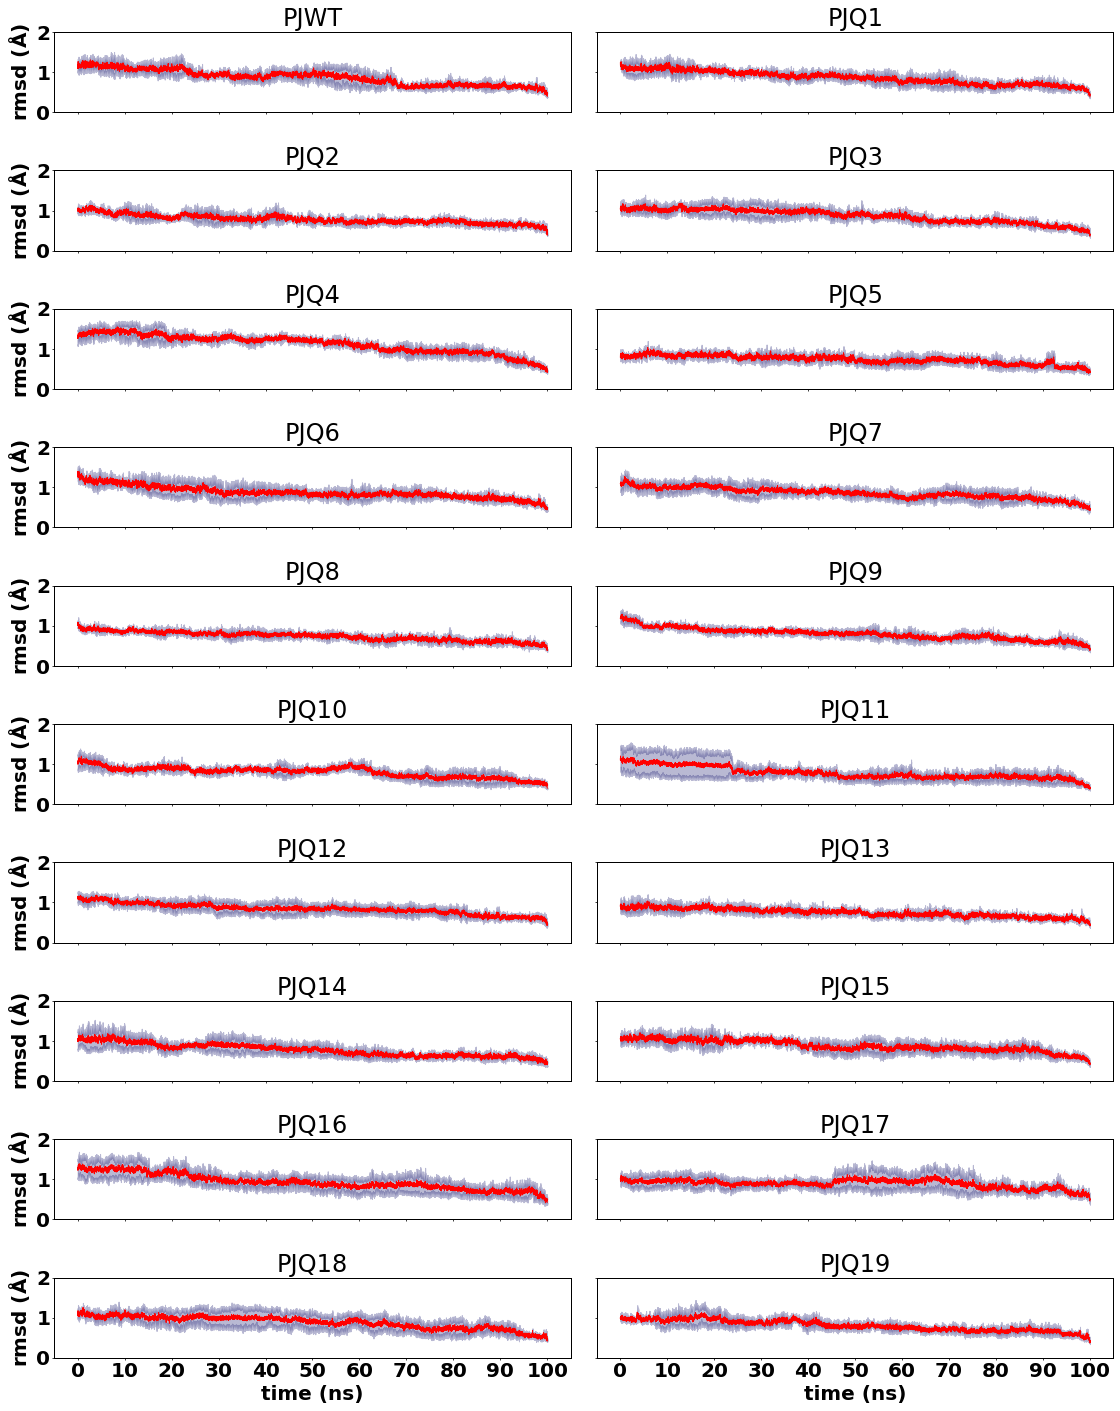

In [71]:
frames = np.arange(20000) # Last frame was used as reference
names = ['PJWT']+['PJQ{}'.format(x) for x in range(1,20, 1)]
cmap = plt.cm.tab20b

fig, axarr = plt.subplots(figsize=(8*2, 2*(len(rmsd)//2)), ncols=2, nrows=len(rmsd)//2, sharex=True, sharey=True)
for i, (ax, key) in enumerate(zip(axarr.flatten(), names)):
    c = cmap(i/(len(rmsd)-1))
    mean = np.mean(rmsd[key], axis=0)
    std = np.std(rmsd[key], axis=0)
    ax.set_title(key)
    ax.plot(frames, mean[:-10], lw=1, c='r', zorder=10)
    ax.fill_between(frames, mean[:-10]+std[:-10], mean[:-10]-std[:-10], color='midnightblue', alpha=0.3, zorder=1)
    ax.set_ylim((0.,2.))
    if not i%2:
        ax.set_ylabel('$\\rm rmsd\ (\\AA)$')
    if i >= len(rmsd)-2: # Because of axarr.flatten() the last two axis are the last row
        ax.set_xlabel('time (ns)')
        ax.set_xticks(np.arange(0, 22000, 2000))
        ax.set_xticklabels(list(map(str, list(range(0, 110, 10)))))
        
plt.tight_layout()
plt.savefig('./figures/rmsd.png', dpi=300, bbox_inches='tight')
plt.show()

In [72]:
com_dist = {}
for name in np.unique(dataset.name):
    com_dist[name] = []
    com_path = dataset[dataset.name==name]
    for fpath in com_path.com_dist:
        with open(fpath, 'r') as fh:
            data = pd.read_csv(fpath)
        com_dist[name].append(data.values.flatten())
        
for k,v in com_dist.items():
    com_dist[k] = np.concatenate(v)
    
com_dist_df = pd.DataFrame().from_dict(com_dist)

dG.sort_values('dG', inplace=True)      
com_dist_df  = com_dist_df.loc[:, dG.index]

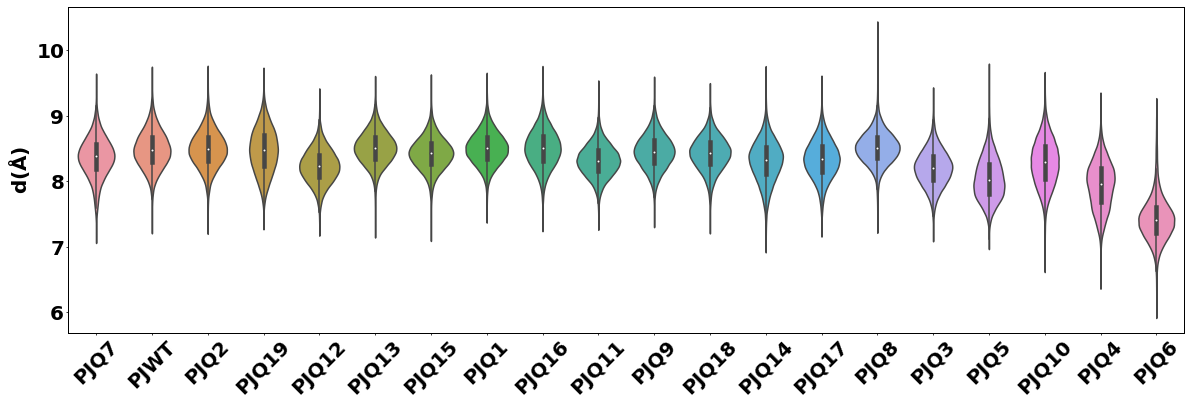

In [77]:
fig = plt.figure(figsize=(20,6))
sns.violinplot(data=com_dist_df)
plt.xlabel('')
plt.xticks(rotation=45)
plt.ylabel('$\\rm d (\\AA)$')
plt.savefig('./figures/com_dist.png', dpi=300, bbox_inches='tight')
plt.show()